# CNN: Algae Image Classification
*A Study of Algae in The Baltic Sea*

In this project we will build and train a neural net to identify algae in images. The training data is from crowd sourced images captured around The Baltic Sea.

**Importance of CNN Models for Predicting Algae in Water**

Water quality continues to be a critical global concern. In environmental monitoring and water quality management, the presence of algae in water bodies can have harmful effects on aquatic ecosystems, human health, and various industries relying on water resources. CNNs excel in image recognition tasks, making them well-suited for analyzing visual data, such as images of water samples.

The ability of CNNs to automatically learn relevant features from input images enables the development of robust predictions. This open doors for early detection of algal blooms and allows for proactiveness.

This notebook contains two models, one built with pyTorch and one with TensorFlow.

In [1]:
import os, json
import pandas as pd
import numpy as np
from urllib.parse import urlparse, unquote

In [2]:
image_dir = ["Data/algae/algal_blooms_sweden_2022", "Data/algae/algal_blooms"]
json_path = ["Data/algae/algal_blooms_sweden_2022/_metadata_2022.json", "Data/algae/algal_blooms/_metadata_2021.json"]

imgfilter = [file for file in os.listdir("Data/algae/water") if file.lower().endswith(('.jpg', '.jpeg', '.png'))]
sin_algae = [os.path.join("Data/algae/water", filename) for filename in imgfilter] # Just water. Will receive label 0.

## Check it

In [3]:
def get_unique_names(dirs):
    all_names, total_unique, total_non_unique = set(), 0, 0

    for image_dir in dirs:
        images = [i for i in os.listdir(image_dir) if not i.endswith(('json', 'csv'))]
        names = [i.split('_')[0] for i in images]

        unique_names_in_dir = set(names) - all_names
        non_unique_names_in_dir = set(names) & all_names

        total_unique += len(unique_names_in_dir)
        total_non_unique += len(non_unique_names_in_dir)
        all_names.update(names)

    return total_unique, total_non_unique

get_unique_names(image_dir)

(310, 0)

All image filename prefixes (a bunch of integers) are unique. We can use the strings up until the first underscore to match urls in the json. This really isn't needed for the CNN model -- but it's neat.

In [4]:
def find_matching_image_path(image_dir, prefix):
    for filename in os.listdir(image_dir):
        if filename.startswith(prefix):
            return os.path.join(image_dir, filename)
    return None

## Parse it

In [5]:
def create_df(json_path, image_dir):
    df = pd.read_json(json_path)

    for index, row in df.iterrows():
        overview_photo = unquote(os.path.basename(urlparse(row["algae_overview_photo"]).path)).split('_')[0]
        detail_photo = unquote(os.path.basename(urlparse(row["algae_detail_photo"]).path)).split('_')[0]

        if overview_photo == "" or detail_photo == "":
            df.at[index, 'algae_overview_photo'] = np.nan
            df.at[index, 'algae_detail_photo'] = np.nan

        else:
            overview_photo_path = find_matching_image_path(image_dir, overview_photo)
            detail_photo_path = find_matching_image_path(image_dir, detail_photo)

            df.at[index, 'algae_overview_photo'] = overview_photo_path if overview_photo_path else np.nan
            df.at[index, 'algae_detail_photo'] = detail_photo_path if detail_photo_path else np.nan

    df.replace("", np.nan, inplace=True)

    return df

df = pd.DataFrame()

for i, j in enumerate(json_path):
    df2 = create_df(j, image_dir[i])
    df = pd.concat([df, df2], ignore_index=True)

df.shape

(412, 9)

We use Pandas to parse the json and iterate over each rows in order to replace the urls with file paths.<br>
The colum names are self-explanatory, but we will make some modifications to them in the next steps.

## Clean it

In [6]:
old = df.shape[0]

df = df.drop('kommun', axis=1)
df = df[~df.apply(lambda row: any('test' in str(cell).lower() for cell in row), axis=1)]
df = df.dropna(subset=['algae_overview_photo', 'algae_detail_photo'], how='any')
df['comments'] = df['comments'].str.strip()
df = df[df['comments'] != 'Luktar illa'] # Invalid positional data: Not in Baltic Sea
df = df[df['report_id'] != '7c2ebee7-0992-4f2b-b180-e65089c53299'] # Invalid data: Not algae
df.drop_duplicates() # No duplicates

print(f"Dropped: {old - df.shape[0]} rows")
df.shape

Dropped: 258 rows


(154, 8)

In [7]:
df['coords'] = list(zip(df['lat'].round(5), df['long'].round(5))) # == 1.11 metres precision
center_lat, center_long = np.mean(df['lat']), np.mean(df['long'])
df = df.drop(['lat', 'long'], axis=1)

In [8]:
df = df[['report_id', 'time_spotted', 'comments', 'place', 'coords', 'algae_overview_photo', 'algae_detail_photo']]
df.columns = ['id', 'date', 'comments', 'place', 'coords', 'overview', 'detail']

In [9]:
df.sample(3)

id        date  \
193  6ddcce17-48ac-4d7b-bc31-4168c41cf755  2021-06-29   
123  42a665f4-051f-4e92-94d3-b1e2039e1409  2022-08-09   
44   3e7b89cc-2462-458b-907e-6d4ca5484af5  2022-06-30   

                                              comments      place  \
193                                                NaN  Stockholm   
123                                  "Avoksdosmoothie"  Stockholm   
44   Flockig gulgrön hinna i utan. Vattnet under re...  Stockholm   

                   coords                                           overview  \
193  (55.82035, 14.35791)  Data/algae/algal_blooms/637606408822375871_210...   
123  (57.27088, 16.95562)  Data/algae/algal_blooms_sweden_2022/6379571149...   
44   (58.80845, 17.55383)  Data/algae/algal_blooms_sweden_2022/6379215869...   

                                                detail  
193  Data/algae/algal_blooms/637606409022632413_210...  
123  Data/algae/algal_blooms_sweden_2022/6379571148...  
44   Data/algae/algal_blooms_sweden_2022/6379215862...

Again, the model really won't benefit from any of this miscellaneous data, as we only train on the images (tensors) and their corresponding label.

## View it

In [10]:
import folium
from folium.plugins import HeatMap

baltic_sea_algea_heatmap = folium.Map(location=[center_lat + 1, center_long], zoom_start=5)

heat_data = [[row['coords'][0], row['coords'][1]] for index, row in df.iterrows()]

HeatMap(heat_data).add_to(baltic_sea_algea_heatmap)

baltic_sea_algea_heatmap.save("Assets/baltic_sea_algae_heatmap.html")
display(baltic_sea_algea_heatmap)

In [11]:
len(df[df['place'] == 'Stockholm'].value_counts())

96

In [12]:
df[df['place'] == 'Stockholm'].value_counts().sample()

id                                    date        comments                                            place      coords                overview                                                                                          detail                                                                                          
41a207ec-438d-4c15-a900-cfe80a858d0d  2022-07-03  Lime green, running north-sea outside Visby harbor  Stockholm  (57.63766, 18.27765)  Data/algae/algal_blooms_sweden_2022/637942592756353200_DAFBEFE3-AFCB-49C7-A89A-CDFD837B7B06.jpeg  Data/algae/algal_blooms_sweden_2022/637942592259335120_F24FF636-3948-4A25-B570-BB3B4A8836B1.jpeg    1
Name: count, dtype: int64

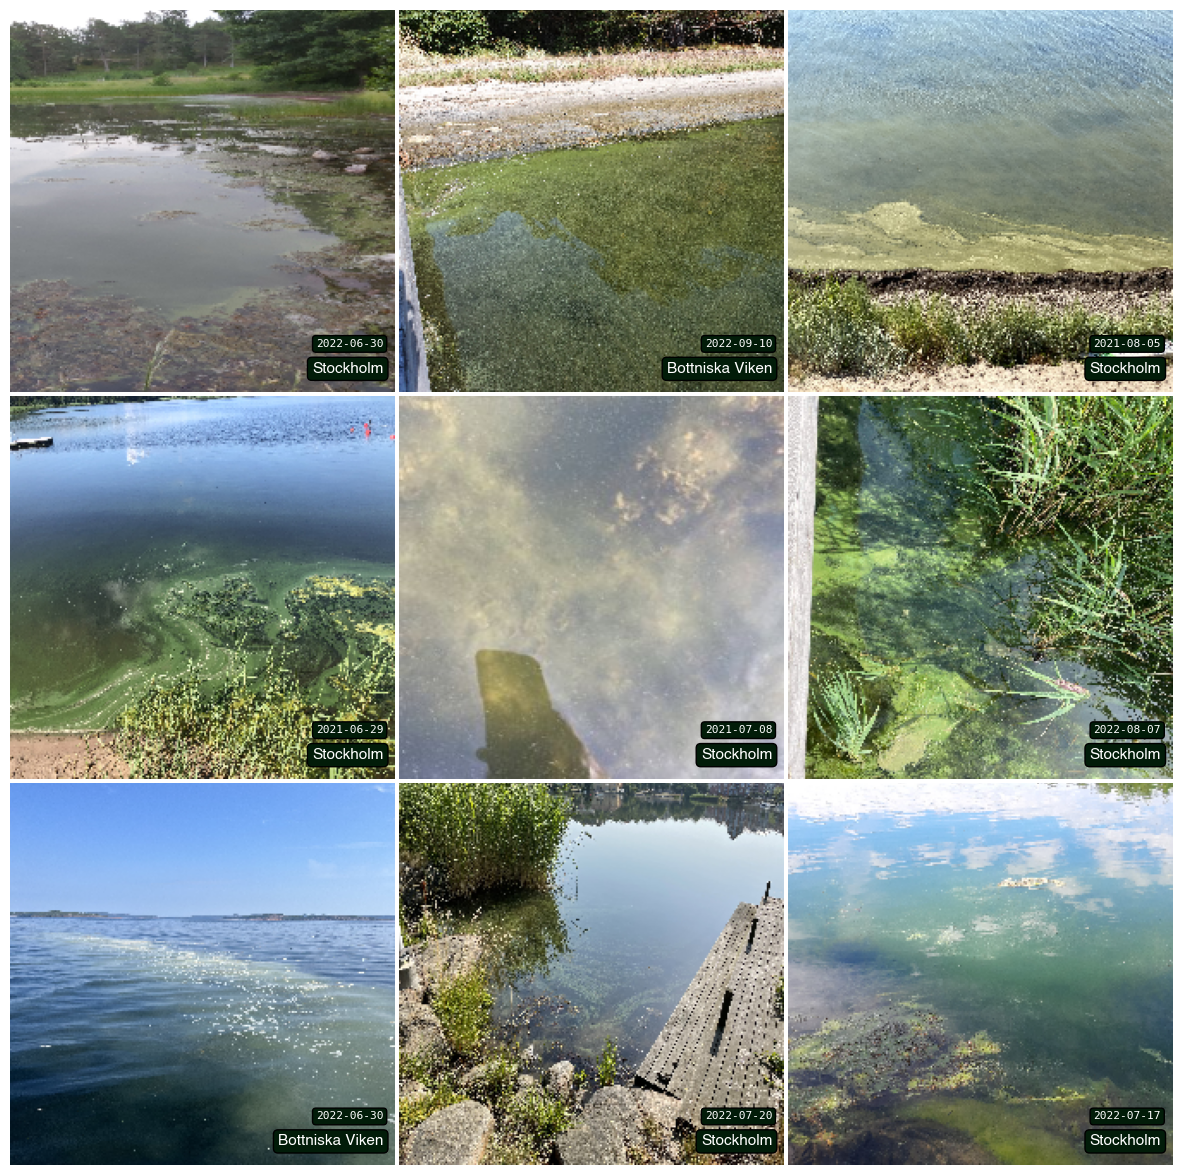

In [13]:
import matplotlib.pyplot as plt
import cv2
np.random.seed(42)

def display_images_grid(df, image_column, target_size=(224, 224), font_size=10, font_family='Helvetica'):
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    fig.subplots_adjust(wspace=0.01, hspace=0.01)

    sample_indices = np.random.choice(len(df), size=min(9, len(df)), replace=False)

    for i, ax in enumerate(axes.flatten()):
        index = sample_indices[i]
        image_path = df[image_column].iloc[index]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, target_size)
        ax.imshow(image, extent=[0, 1, 0, 1], aspect='auto')

        ax.text(0.97, 0.14, df.iloc[index]['date'], fontsize=font_size-2, fontfamily='monospace',
            color='#ffffff', ha='right', va='top',
            bbox=dict(boxstyle='round', alpha=1, facecolor='#021c09'))

        ax.text(0.97, 0.08, df.iloc[index]['place'], fontsize=font_size+1, fontfamily=font_family,
                color='#ffffff', ha='right', va='top',
                bbox=dict(boxstyle='round', alpha=1, facecolor='#021c09'))

        ax.axis('off')

    plt.show()
display_images_grid(df, 'overview')

## Size it

In [14]:
from PIL import Image

df['overview_resolution'] = None
df['detail_resolution'] = None

for index, row in df.iterrows():
    overview_path = row['overview']
    detail_path = row['detail']

    overview_image = Image.open(overview_path)
    overview_resolution = overview_image.size
    df.at[index, 'overview_resolution'] = overview_resolution
    
    detail_image = Image.open(detail_path)
    detail_resolution = detail_image.size
    df.at[index, 'detail_resolution'] = detail_resolution

In [15]:
np.mean(np.array(df['overview_resolution'].tolist()), axis=0), np.mean(np.array(df['detail_resolution'].tolist()), axis=0)

(array([3279.64285714, 2624.33766234]), array([3264.27922078, 2629.11688312]))

The resolutions are quite high. Which means the tensors will be quite large. We address this in the next step.

## Shrink it

In [16]:
import torch
from torchvision import transforms as T
from typing import Optional, Callable
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image

def load_and_preprocess_images(image_paths):
    transform_function = T.Compose([T.Resize(224),
                                      T.CenterCrop(224),
                                      T.ToTensor(),
                                      ])

    images = [transform_function(Image.open(path).convert("RGB")) for path in image_paths]
    return np.array([img_to_array(img) for img in images])

2024-01-31 17:03:31.726648: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Build a model

In [17]:
import torch.nn as nn
from torchsummary import summary

class CustomModel(nn.Module):
    def __init__(self, img = [224, 224],
                 n_filters = [16, 32, 64],
                 pool_size = [2, 2, 2],
                 activates = ['relu', 'relu', 'relu'],
                 dense_units = [128], dense_activations = ['relu']):
        super(CustomModel, self).__init__()

        layers = []
        in_channels = 3 # RGB

        # Conv layers
        for filters, pooling_size, activates in zip(n_filters, pool_size, activates):
            layers.append(nn.Conv2d(in_channels, filters, kernel_size=3, padding='same'))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.MaxPool2d(kernel_size=pooling_size))
            in_channels = filters

        conv_output_size = self._get_conv_output_size(img, in_channels, n_filters, pool_size)
        layers.append(nn.Flatten())

        # Dense (Fully connected) layers
        for units, activation in zip(dense_units, dense_activations):
            layers.append(nn.Linear(conv_output_size, units))
            layers.append(nn.ReLU(inplace=True))
            conv_output_size = units

        # Output layer
        layers.append(nn.Linear(conv_output_size, 1))
        layers.append(nn.Sigmoid())

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

    def _get_conv_output_size(self, img, in_channels, n_filters, pool_size):
        # Helper function to calculate the output size after convolutional layers
        x = torch.randn(1, in_channels, img[0], img[1])
        for i in range(len(n_filters)):
            x = nn.Conv2d(in_channels, n_filters[i], kernel_size=3, padding='same')(x)
            x = nn.ReLU(inplace=True)(x)
            x = nn.MaxPool2d(kernel_size=pool_size[i])(x)
            in_channels = n_filters[i]

        return x.view(1, -1).size(1)

# Testing with random noise
model = CustomModel()
input_tensor = torch.randn((32, 3, 224, 224))
output = model(input_tensor)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
              ReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
              ReLU-8           [-1, 64, 56, 56]               0
         MaxPool2d-9           [-1, 64, 28, 28]               0
          Flatten-10                [-1, 50176]               0
           Linear-11                  [-1, 128]       6,422,656
             ReLU-12                  [-1, 128]               0
           Linear-13                    [-1, 1]             129
          Sigmoid-14                   

-1 in the output shape represents a dynamic dimension which is inferred based on the input size.

## Merge it

In [18]:
algae = df['detail'].drop_duplicates().tolist()
algae.extend(df['overview'].drop_duplicates().tolist())

X = sin_algae + algae
y = [0] * len(sin_algae) + [1] * (len(algae))

len(X) == len(y)

True

We create our dataset and labels by merging the algae and the non-algare images along with the labels (0,1)

## Split it

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

len(X_train), len(X_test)

(333, 38)

A typical split.

## Prep it

In [20]:
from torch.utils.data import DataLoader, TensorDataset

# Apply the transforms (crop, resize, #TODO Normalization)
X_train_images = load_and_preprocess_images(X_train)
X_test_images = load_and_preprocess_images(X_test)

# Convert to tensors and create DataLoader for train and test
X_train_tensor = torch.tensor(X_train_images)
y_train_tensor = torch.tensor(y_train).unsqueeze(1)  # Add a dimension for binary classification

X_test_tensor = torch.tensor(X_test_images)
y_test_tensor = torch.tensor(y_test).unsqueeze(1)

batch_size = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

We perform the transformations and and populate our DataLoader with tensors. In the next step we'll start training.

## Train it

In [21]:
from torch.utils.tensorboard import SummaryWriter

model = CustomModel()
writer = SummaryWriter()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Store metrics for plotting outside TensorBoard
train_losses, test_losses, accuracies = [],[],[]

epochs = 10
for epoch in range(epochs):
    model.train()
    epoch_train_losses = []

    for inputs, labels in train_loader:
        optimizer.zero_grad()    # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels.float())  # Get loss
        loss.backward()   # Backward pass
        optimizer.step()  # Update weights

        epoch_train_losses.append(loss.item())

    # Average training loss for the epoch
    train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    train_losses.append(train_loss)

    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            test_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate accuracy
        accuracy = correct / total
        accuracies.append(accuracy)

        # Record the average test loss for the epoch
        test_losses.append(test_loss / len(test_loader))

        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss:.4f}, Test Loss: {test_loss / len(test_loader):.4f}, Accuracy: {accuracy * 100:.2f}%")

writer.close()

Epoch 1/10, Training Loss: 0.6382, Test Loss: 0.7389, Accuracy: 65.79%
Epoch 2/10, Training Loss: 0.5162, Test Loss: 0.6036, Accuracy: 63.16%
Epoch 3/10, Training Loss: 0.4626, Test Loss: 0.5488, Accuracy: 73.68%
Epoch 4/10, Training Loss: 0.4505, Test Loss: 0.7319, Accuracy: 65.79%
Epoch 5/10, Training Loss: 0.3922, Test Loss: 0.5844, Accuracy: 76.32%
Epoch 6/10, Training Loss: 0.3298, Test Loss: 0.4611, Accuracy: 84.21%
Epoch 7/10, Training Loss: 0.2940, Test Loss: 0.4454, Accuracy: 86.84%
Epoch 8/10, Training Loss: 0.2605, Test Loss: 0.4836, Accuracy: 76.32%
Epoch 9/10, Training Loss: 0.2337, Test Loss: 0.3685, Accuracy: 84.21%
Epoch 10/10, Training Loss: 0.1727, Test Loss: 0.2895, Accuracy: 89.47%


Could finetune better.

## Viz it

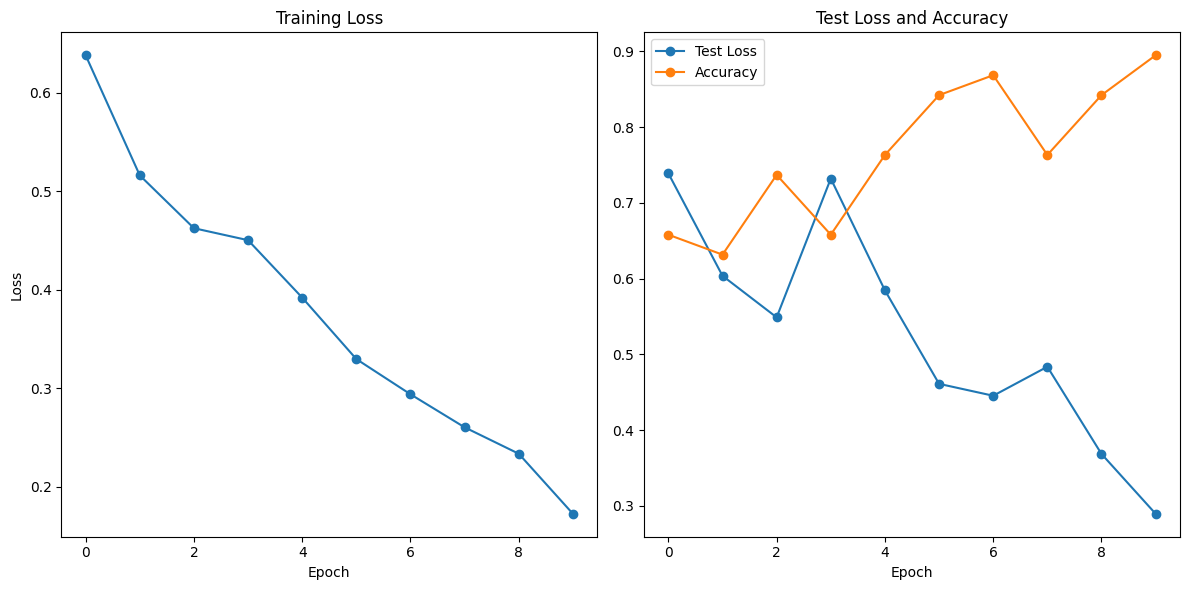

In [22]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(test_losses, label='Test Loss', marker='o')
plt.plot(accuracies, label='Accuracy', marker='o')
plt.title('Test Loss and Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

## Tune it

In [23]:
#TODO

## Make inference

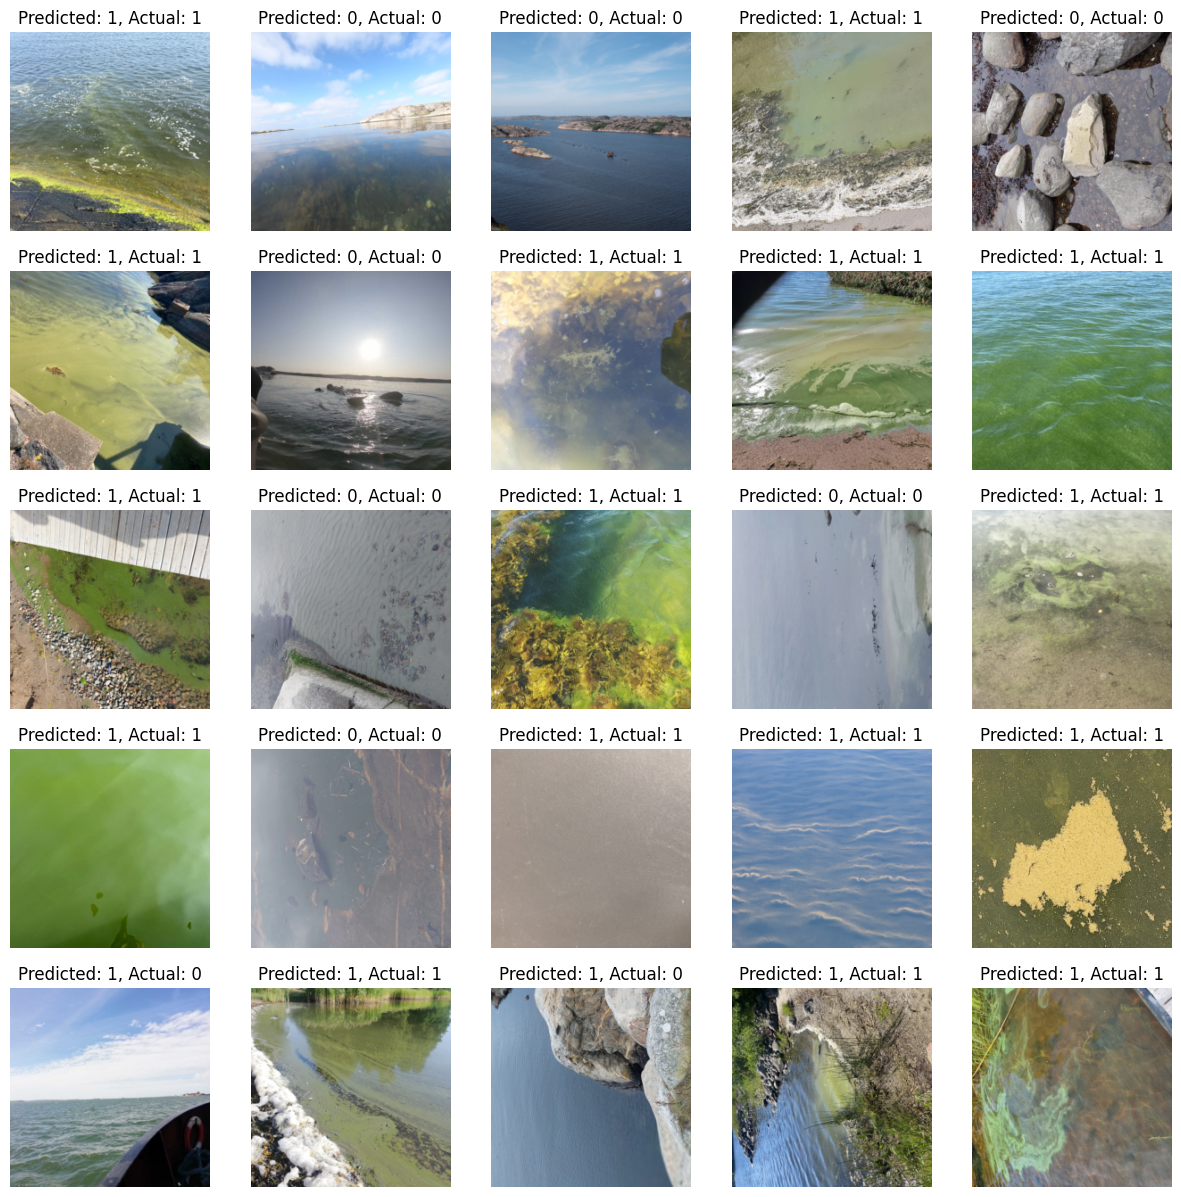

In [24]:
from torchvision.transforms.functional import to_pil_image

def visualize_predictions(model, test_loader, num_rows=5, num_cols=5):
    model.eval()

    data_iterator = iter(test_loader)
    samples, labels = next(data_iterator)
    
    with torch.no_grad():
        outputs = model(samples)
        predicted_labels = (outputs > 0.5).float()

    # Convert samples to PIL images
    sample_images = [to_pil_image(sample) for sample in samples]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

    for i in range(num_rows):
        for j in range(num_cols):
            idx = i * num_cols + j
            axes[i, j].imshow(sample_images[idx])
            axes[i, j].axis('off')
            axes[i, j].set_title(f'Predicted: {int(predicted_labels[idx])}, Actual: {int(labels[idx])}')

    plt.show()

visualize_predictions(model, test_loader, num_rows=5, num_cols=5)

# Technologic
## Technologic
### Technologic

# Bonus - Keras Model

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import img_to_array
from tqdm import tqdm

def apply_transforms(image):
    image = image.resize((224, 224))
    return img_to_array(image)

def get_model(img_size=[224, 224], num_filters=[16, 32, 64], pooling_sizes=[2, 2, 2],
              activations=['relu', 'relu', 'relu'], dense_units=[128], dense_activations=['relu'],
              optimizer='adam', loss='binary_crossentropy', learning_rate=0.001):
    
    model = Sequential()

    for filters, pooling_size, activation in zip(num_filters, pooling_sizes, activations):
        model.add(Conv2D(filters, 3, padding='same', activation=activation, input_shape=(img_size[0], img_size[1], 3)))
        model.add(MaxPooling2D(pool_size=pooling_size))

    model.add(Flatten())

    for units, activation in zip(dense_units, dense_activations):
        model.add(Dense(units, activation=activation))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model

def load_and_preprocess_images(image_paths):
    images = [apply_transforms(Image.open(path).convert("RGB")) for path in tqdm(image_paths, desc="Resizing Images")]
    return np.array([img_to_array(img) for img in images])

def train_binary_classification_model(model, X_train, y_train, validation_split=0.2, batch_size=32, epochs=10):
    print("running")
    X_train_images = load_and_preprocess_images(X_train)
    y_train = np.array(y_train)

    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_train_images, y_train, test_size=validation_split, random_state=42
    )

    history = model.fit(
        X_train_split, y_train_split,
        validation_data=(X_val_split, y_val_split),
        batch_size=batch_size, epochs=epochs
    )

    return history

model = get_model()
train_binary_classification_model(model, X_train, y_train)


running


Resizing Images: 100%|██████████| 333/333 [01:08<00:00,  4.89it/s]


Epoch 1/10
9/9 [==============================] - 6s 561ms/step - loss: 322.0792 - accuracy: 0.6316 - val_loss: 2.0410 - val_accuracy: 0.7910
Epoch 2/10
9/9 [==============================] - 5s 565ms/step - loss: 22.6143 - accuracy: 0.5714 - val_loss: 11.0386 - val_accuracy: 0.7910
Epoch 3/10
9/9 [==============================] - 5s 581ms/step - loss: 5.0766 - accuracy: 0.5865 - val_loss: 0.5964 - val_accuracy: 0.7910
Epoch 4/10
9/9 [==============================] - 5s 580ms/step - loss: 0.9552 - accuracy: 0.7707 - val_loss: 0.9375 - val_accuracy: 0.4627
Epoch 5/10
9/9 [==============================] - 5s 596ms/step - loss: 0.5237 - accuracy: 0.7331 - val_loss: 0.4116 - val_accuracy: 0.7910
Epoch 6/10
9/9 [==============================] - 5s 574ms/step - loss: 0.2334 - accuracy: 0.9023 - val_loss: 0.3165 - val_accuracy: 0.7910
Epoch 7/10
9/9 [==============================] - 5s 570ms/step - loss: 0.1503 - accuracy: 0.9398 - val_loss: 0.3121 - val_accuracy: 0.9254
Epoch 8/10
9/9 [

Resizing Images: 100%|██████████| 38/38 [00:08<00:00,  4.46it/s]


2/2 [==============================] - 0s 42ms/step


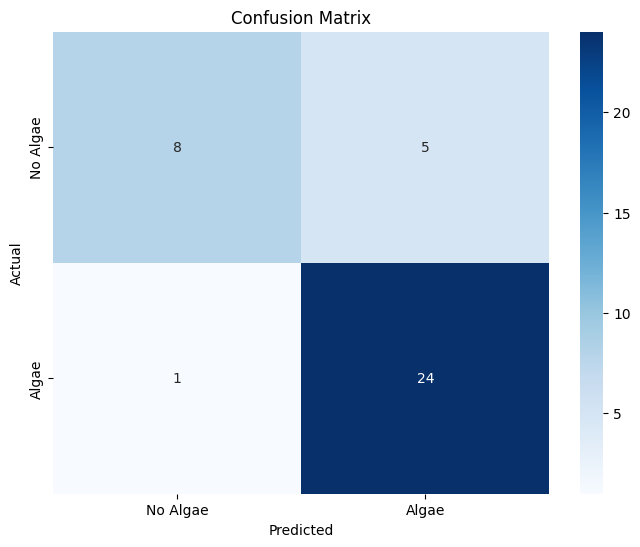

In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

X_test_images = load_and_preprocess_images(X_test)

y_pred = model.predict(X_test_images)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Algae', 'Algae'], yticklabels=['No Algae', 'Algae'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [30]:
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}\n')
print(classification_rep)

Accuracy: 0.8421

              precision    recall  f1-score   support

           0       0.89      0.62      0.73        13
           1       0.83      0.96      0.89        25

    accuracy                           0.84        38
   macro avg       0.86      0.79      0.81        38
weighted avg       0.85      0.84      0.83        38



# Evaluation of Keras Model

#### Training Performance

**Loss and Accuracy:**<br>
The training process shows a decrease in loss over the epochs, accompanied by an increase in accuracy. However, the initial loss is significantly high, suggesting that the model has room for improvement. By the end of training the accuracy reaches 99.25%, indicating that the model is learning fairly well from the training data.

**Validation Loss and Accuracy:**<br>
The validation loss and accuracy fluctuates. The model seems to overfit as the training progresses, especially in the large gap between training and validation accuracy from epoch 4 onwards. This could be a sign of the model memorizing the training data rather than generalizing well to new data.

**Resizing Images:**<br>
The resizing of images is very slow, ~68 seconds for 333 images.

#### Evaluation Performance:

**Overall Accuracy:**<br>
The model achieves an accuracy of 84.21% on the evaluation dataset. While this is a respectable performance, it is slightly lower than the training accuracy, reinforcing the idea of overfitting.

**Precision, Recall, and F1-Score:**<br>
The model seems to perform better at identifying algae (higher recall) but struggles with precision for class 0 (no algae). The F1-score, a balance of precision and recall, is decent but could be improved, especially for class 0 (no algae).

**Support:**<br>
The model might not have sufficient data for class 0 (no algae), potentially affecting its performance.

#### Potential Improvements:

**Data Balancing:**<br> Balancing the dataset, especially if there is an imbalance between classes, could enhance the model's ability to classify algae accurately.

**Regularization Techniques:**<br> Incorporating reg techniques such as dropout balance the overfitting and improve generalization.

**Hyperparameter Tuning:**<br> Experimenting with different learning rates, batch sizes, or model architectures might yield better results.

**Data Augmentation:**<br> Applying data aug techniques during training could help the model become more robust to variations in input data (rotate/mirror images, hue adjustments etc.).

In conclusion, while the model demonstrates a high training accuracy, there is room for improvement in terms of generalization to new data and fine-tuning to achieve better balance between precision and recall.